### Part 1-3

In [1]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB

# Load and process data
def load_and_process_data(file_path):
    df = pd.read_csv(file_path)
    
    # Null Imputation
    df.set_index('Date', inplace=True)
    df.sort_index(inplace=True)
    df = df.ffill().bfill()
    
    # Returns
    returns = df.pct_change()
    returns = returns.ffill().bfill()
    index_returns = returns['NDX']
    stock_returns = returns.drop('NDX', axis=1)
    
    return returns, index_returns, stock_returns

# Calculate correlation matrix of stock returns
def calculate_correlation_matrix(stock_returns):
    return stock_returns.corr()

# Select stocks using IP
def select_stocks(correlation_matrix, m):
    n = correlation_matrix.shape[0] # Total number of stocks in index
    model = gp.Model()

    # Create binary decision variables
    x = model.addVars(n, n, vtype=GRB.BINARY)  # x[i,j] = 1 if stock j is the best representation of stock i
    y = model.addVars(n, vtype=GRB.BINARY)     # y[j] = 1 if stock j is selected

    # Set objective: maximize sum of correlations between selected stocks
    model.setObjective(gp.quicksum(correlation_matrix.iloc[i,j] * x[i,j] for i in range(n) for j in range(n)), GRB.MAXIMIZE)

    # Add constraints
    model.addConstr(gp.quicksum(y[j] for j in range(n)) == m)  # Select exactly m stocks
    for i in range(n):
        model.addConstr(gp.quicksum(x[i,j] for j in range(n)) == 1)  # Each stock must be represented once
    for i in range(n):
        for j in range(n):
            model.addConstr(x[i,j] <= y[j])  # Stock j can represent stock i only if it's selected
    # If stock j represents any other stock (any x[i,j] = 1), then stock j must be in the fund (y[j] must be 1)

    # Optimize
    model.Params.OutputFlag = 0 
    model.optimize()

    # List of selected stock indices
    selected_stocks = [j for j in range(n) if y[j].X > 0.5]
    return selected_stocks

# Calculate weights using LP
def calculate_weights(selected_stocks, stock_returns, index_returns):
    m = len(selected_stocks)
    T = len(index_returns)
    model = gp.Model()

    # Create variables
    w = model.addVars(m, lb=0, ub=1)  # Weights for selected stocks
    z = model.addVars(T, lb=0)        # Absolute difference between portfolio and index returns for T time periods

    # Obj: Minimize(sum of absolute differences)
    model.setObjective(gp.quicksum(z[t] for t in range(T)), GRB.MINIMIZE)

    # Constraints
    model.addConstr(gp.quicksum(w[i] for i in range(m)) == 1)  # Weights sum to 1
    for t in range(T):
        # Absolute difference constraints
        model.addConstr(z[t] >= index_returns.iloc[t] - gp.quicksum(w[i] * stock_returns.iloc[t, selected_stocks[i]] for i in range(m)))
        model.addConstr(z[t] >= gp.quicksum(w[i] * stock_returns.iloc[t, selected_stocks[i]] for i in range(m)) - index_returns.iloc[t])

    # Optimize
    model.Params.OutputFlag = 0 
    model.optimize()

    # List of weights for selected stocks
    weights = [w[i].X for i in range(m)]
    return weights

# Evaluate portfolio performance by calculating tracking error
def evaluate_performance(selected_stocks, weights, stock_returns, index_returns):
    # Calculate portfolio returns
    portfolio_returns = stock_returns.iloc[:, selected_stocks].dot(weights)
    # Calculate tracking error as sum of absolute differences
    tracking_error = np.sum(np.abs(index_returns - portfolio_returns))
    return tracking_error

# Main execution function
def main():
    # Data
    returns_2023, index_returns_2023, stock_returns_2023 = load_and_process_data('2023data.csv')
    returns_2024, index_returns_2024, stock_returns_2024 = load_and_process_data('2024data.csv')

    # Correlation matrix using 2023 data
    correlation_matrix = calculate_correlation_matrix(stock_returns_2023)

    # Run for different values of m (number of stocks to select)
    results = []
    for m in [5] + list(range(10, min(101, stock_returns_2023.shape[1] + 1), 10)):
        # Select stocks based on 2023 data
        selected_stocks = select_stocks(correlation_matrix, m)

        # Calculate weights based on 2023 data
        weights = calculate_weights(selected_stocks, stock_returns_2023, index_returns_2023)

        # Evaluate in-sample performance (2023)
        tracking_error_2023 = evaluate_performance(selected_stocks, weights, stock_returns_2023, index_returns_2023)

        # Evaluate out-of-sample performance (2024)
        tracking_error_2024 = evaluate_performance(selected_stocks, weights, stock_returns_2024, index_returns_2024)

        results.append({
            'm': m,
            'tracking_error_2023': tracking_error_2023,
            'tracking_error_2024': tracking_error_2024
        })

        print(f"m = {m}: 2023 Tracking Error = {tracking_error_2023}, 2024 Tracking Error = {tracking_error_2024}")

    return results

if __name__ == "__main__":
    results = main()

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-26
m = 5: 2023 Tracking Error = 1.1795434911991451, 2024 Tracking Error = 1.1382747761827017
m = 10: 2023 Tracking Error = 0.9727565274965169, 2024 Tracking Error = 0.8714141292693738
m = 20: 2023 Tracking Error = 0.906235459873394, 2024 Tracking Error = 0.7687056993085437
m = 30: 2023 Tracking Error = 0.7956650449190242, 2024 Tracking Error = 0.7337725010648575
m = 40: 2023 Tracking Error = 0.7704707490945333, 2024 Tracking Error = 0.7329229303193479
m = 50: 2023 Tracking Error = 0.575208358915795, 2024 Tracking Error = 0.6720714096147171
m = 60: 2023 Tracking Error = 0.5530671152536124, 2024 Tracking Error = 0.6935950405369529
m = 70: 2023 Tracking Error = 0.3928592205068654, 2024 Tracking Error = 0.6022680874064195
m = 80: 2023 Tracking Error = 0.2667997552957921, 2024 Tracking Error = 0.5088877046427159
m = 90: 2023 Tracking Error = 0.21659777178244818, 2024 Tracking Error = 0.4208175827988879
m

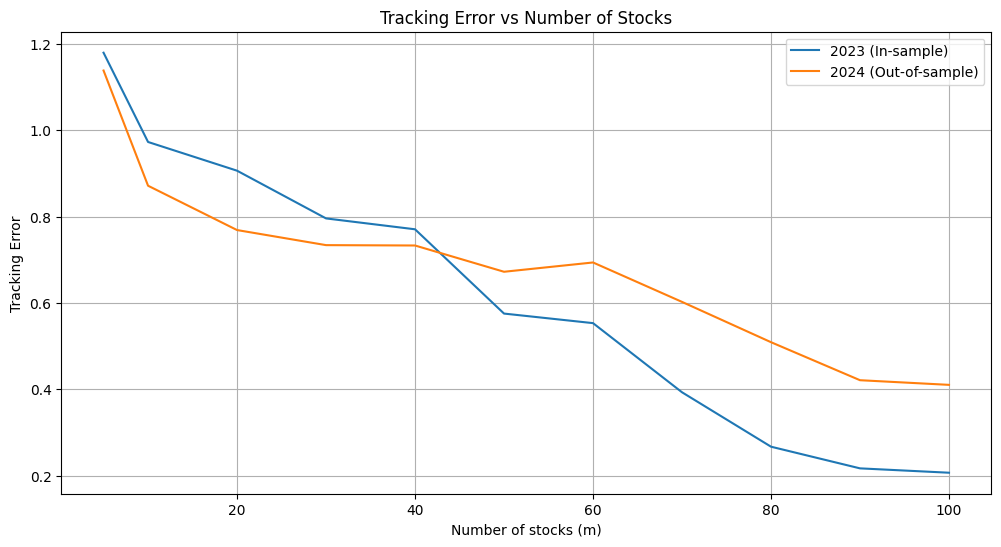

In [2]:
import matplotlib.pyplot as plt

# Calculate percentage improvements
for i in range(1, len(results)):
    results[i]['improvement_2023'] = (results[i-1]['tracking_error_2023'] - results[i]['tracking_error_2023']) / results[i-1]['tracking_error_2023'] * 100
    results[i]['improvement_2024'] = (results[i-1]['tracking_error_2024'] - results[i]['tracking_error_2024']) / results[i-1]['tracking_error_2024'] * 100

# Find point of diminishing returns (e.g., where improvement falls below 5%)
diminishing_returns_point = next((r['m'] for r in results if r.get('improvement_2024', 100) < 5), None)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot([r['m'] for r in results], [r['tracking_error_2023'] for r in results], label='2023 (In-sample)')
plt.plot([r['m'] for r in results], [r['tracking_error_2024'] for r in results], label='2024 (Out-of-sample)')
plt.xlabel('Number of stocks (m)')
plt.ylabel('Tracking Error')
plt.title('Tracking Error vs Number of Stocks')
plt.legend()
plt.grid(True)
plt.show()

### Performance Analysis

1. Tracking Error Trends:
   - As  m  increases, both the 2023 and 2024 tracking errors generally decrease. This suggests that including more stocks in the portfolio improves its ability to track the index.

2. Diminishing Returns:
   - The improvement in tracking error diminishes as  m  increases. For instance, the reduction in tracking error from  m = 90  to  m = 100  is much smaller compared to earlier increments. This indicates diminishing returns when adding more stocks beyond a certain point.

3. In-Sample vs. Out-of-Sample Performance:
   - The tracking error is consistently lower in 2023 (in-sample) compared to 2024 (out-of-sample). This is expected because the portfolio was optimized using 2023 data. The difference highlights how market conditions and stock behaviors can change year over year, affecting out-of-sample performance.

### Why Performance Differs Between 2023 and 2024

1. Market Changes:
   - Market conditions, such as volatility and trends, can differ between years, impacting how well a portfolio tracks an index.

2. Correlation Shifts:
   - The correlation between stocks may change over time, affecting how representative the selected stocks are of the entire index in different years.

3. Optimization Bias:
   - The optimization process tailors the portfolio to past data (2023), which may not perfectly predict future performance (2024).

### Recommendations

- Optimal Value of  m : 
  - Choose a value of  m  where tracking error improvements become marginal (e.g., around  m = 70  or  m = 80 ) to balance between tracking accuracy and portfolio manageability.

- Consideration for Future Portfolios:
  - Regularly update the selection and weighting process to adapt to changing market conditions.

This analysis should provide a comprehensive view of how well your portfolio construction method performs across different scenarios and help make informed decisions about future index fund strategies.


### Part 4

In [ ]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB

# Set time limit for Gurobi
TIME_LIMIT = 3600

# Load and process data
def load_and_process_data(file_path):
    df = pd.read_csv(file_path)
    df.set_index('Date', inplace=True)
    df.sort_index(inplace=True)
    df = df.ffill().bfill()
    
    returns = df.pct_change().ffill().bfill()
    index_returns = returns['NDX']
    stock_returns = returns.drop('NDX', axis=1)
    
    return returns, index_returns, stock_returns

# Calculate weights using MIP
def calculate_weights_mip(stock_returns, index_returns, m, time_limit):
    n = stock_returns.shape[1]
    T = len(index_returns)
    M = 1.0  # Big M value, assuming weights are between 0 and 1

    model = gp.Model()

    # Create variables
    w = model.addVars(n, lb=0, ub=1, name="w")
    y = model.addVars(n, vtype=GRB.BINARY, name="y")
    z = model.addVars(T, lb=0, name="z")

    # Set objective: minimize sum of absolute differences
    model.setObjective(gp.quicksum(z[t] for t in range(T)), GRB.MINIMIZE)

    # Add constraints
    model.addConstr(gp.quicksum(y[i] for i in range(n)) == m)  # Limit number of non-zero weights to m
    model.addConstr(gp.quicksum(w[i] for i in range(n)) == 1)  # Weights sum to 1

    for i in range(n):
        model.addConstr(w[i] <= M * y[i])  # Big M constraint

    for t in range(T):
        model.addConstr(z[t] >= index_returns.iloc[t] - gp.quicksum(w[i] * stock_returns.iloc[t, i] for i in range(n)))
        model.addConstr(z[t] >= gp.quicksum(w[i] * stock_returns.iloc[t, i] for i in range(n)) - index_returns.iloc[t])

    # Set time limit
    model.Params.TimeLimit = time_limit
    model.Params.OutputFlag = 0 
    model.optimize()

    # Extract results
    selected_stocks = [i for i in range(n) if y[i].X > 0.5]
    weights = [w[i].X for i in range(n)]
    
    return selected_stocks, weights

# Evaluate portfolio performance by calculating tracking error
def evaluate_performance(selected_stocks, weights, stock_returns, index_returns):
    portfolio_returns = stock_returns.iloc[:, selected_stocks].dot(weights)
    tracking_error = np.sum(np.abs(index_returns - portfolio_returns))
    return tracking_error

# Main execution function
def main():
    # Load and process data for 2023 and 2024
    returns_2023, index_returns_2023, stock_returns_2023 = load_and_process_data('2023data.csv')
    returns_2024, index_returns_2024, stock_returns_2024 = load_and_process_data('2024data.csv')

    results = []
    
    # Run for different values of m (number of stocks to select)
    for m in [5] + list(range(10, min(101, stock_returns_2023.shape[1] + 1), 10)):
        selected_stocks, weights = calculate_weights_mip(stock_returns_2023, index_returns_2023, m, TIME_LIMIT)

        # Ensure selected stocks and weights have compatible dimensions
        selected_weights = [weights[i] for i in selected_stocks]

        # Evaluate in-sample performance (2023)
        tracking_error_2023 = evaluate_performance(selected_stocks, selected_weights, stock_returns_2023, index_returns_2023)

        # Evaluate out-of-sample performance (2024)
        tracking_error_2024 = evaluate_performance(selected_stocks, selected_weights, stock_returns_2024, index_returns_2024)

        results.append({
            'm': m,
            'tracking_error_2023': tracking_error_2023,
            'tracking_error_2024': tracking_error_2024
        })

        print(f"m = {m}: 2023 Tracking Error = {tracking_error_2023}, 2024 Tracking Error = {tracking_error_2024}")

if __name__ == "__main__":
    main()

Set parameter TimeLimit to value 3600
m = 5: 2023 Tracking Error = 0.7538861767574824, 2024 Tracking Error = 0.9122020972641656
Set parameter TimeLimit to value 3600
m = 10: 2023 Tracking Error = 0.46031464127650334, 2024 Tracking Error = 0.6809326431113799
Set parameter TimeLimit to value 3600
m = 20: 2023 Tracking Error = 0.3064634556191456, 2024 Tracking Error = 0.4684188083071628
Set parameter TimeLimit to value 3600
